In [1]:
import numpy as np
import math
from scipy.stats import norm, poisson
from scipy.optimize import fsolve
from scipy import integrate

### 1.a) Guaranteed Service

In [2]:
# Parameters
review_period = 1
lead_time = [2, 1, 1]
holding_cost = [1, 2, 5]
mu = 50
sigma = 20
alpha = 0.9
n_stage = len(holding_cost)

# Possible allocation cadidates
candidates = np.array([[0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 1, 1]])


def func_coverage_time(decision):
    cover_time = np.zeros(n_stage)
    cumulative_time = 0
    for i in range(n_stage - 1):
        if decision[i] == 1:
            cover_time[i] = lead_time[i] + cumulative_time
            cumulative_time = 0
        else:
            cover_time[i] = 0
            cumulative_time += lead_time[i]
    cover_time[n_stage - 1] = lead_time[i] + review_period + cumulative_time
    return cover_time


coverage_time = np.zeros_like(candidates)
for i in range(len(candidates)):
    coverage_time[i] = func_coverage_time(candidates[i])
print("Allocation cadidates: \n" + str(candidates))
print("Coverage time: \n" + str(coverage_time))

Allocation cadidates: 
[[0 0 1]
 [0 1 1]
 [1 0 1]
 [1 1 1]]
Coverage time: 
[[0 0 5]
 [0 3 2]
 [2 0 3]
 [2 1 2]]


### 1.b)

In [3]:
safety_factor = norm.ppf(alpha)
print(safety_factor)

1.2815515655446004


In [4]:
safety_stock = np.array([safety_factor * sigma * np.sqrt(t) for t in coverage_time])
print("Safety stock: \n" + str(safety_stock))

total_cost_candidates = np.sum(holding_cost * safety_stock, axis=1)
print("Total cost: \n" + str(total_cost_candidates))

opt_candidate = candidates[np.argmin(total_cost_candidates)]
print("Optimal allocation: \n" + str(opt_candidate))

Safety stock: 
[[ 0.          0.         57.31272834]
 [ 0.         44.39424848 36.2477521 ]
 [36.2477521   0.         44.39424848]
 [36.2477521  25.63103131 36.2477521 ]]
Total cost: 
[286.56364172 270.02725745 258.2189945  268.74857521]
Optimal allocation: 
[1 0 1]


### 2.a) Clark-Scarf-model

In [5]:
# Parameters
lead_time = [1, 1]
mu = 100
sigma = 40
holding_cost = [1, 3]
penalty_cost = 20

In [6]:
# Optimal Solutions Stage 2
critical_ratio_s2 = (holding_cost[0] + penalty_cost) / (holding_cost[1] + penalty_cost)
opt_s2 = norm.ppf(
    critical_ratio_s2, mu * (lead_time[1] + 1), sigma * math.sqrt(lead_time[1] + 1)
)

print("Optimal Order-up-to Level (S2): " + str(np.round(opt_s2, 2)))


# Optimal Solutions Stage 1
def func_s1(s1):
    critical_ratio_s1 = penalty_cost / (holding_cost[1] + penalty_cost)
    # Integrate func from 0 to opt_s2
    integral = integrate.quad(
        lambda d: norm.cdf(s1 - d, mu * lead_time[0], sigma * math.sqrt(lead_time[0]))
        * norm.pdf(d, mu * (lead_time[1] + 1), sigma * math.sqrt(lead_time[1] + 1)),
        0,
        opt_s2,
    )[0]
    return integral - critical_ratio_s1


opt_s1 = fsolve(func_s1, opt_s2)

print("Optimal Order-up-to Level (S1): " + str(np.round(opt_s1[0], 2)))

Optimal Order-up-to Level (S2): 276.92
Optimal Order-up-to Level (S1): 390.75


### 2.b)

In [7]:
# adjust penalty level
critical_ratio_s1_new = 0.95
penalty_cost_new = int(
    np.floor(
        (holding_cost[1] * critical_ratio_s1_new) / (1 - critical_ratio_s1_new) + 1
    )
)
print(penalty_cost_new)

57


In [8]:
# Optimal Solutions Stage 2
critical_ratio_s2 = (holding_cost[0] + penalty_cost_new) / (
    holding_cost[1] + penalty_cost_new
)
opt_s2_new = norm.ppf(
    critical_ratio_s2, mu * (lead_time[1] + 1), sigma * math.sqrt(lead_time[1] + 1)
)

print("New Optimal Order-up-to Level (S2): " + str(np.round(opt_s2_new, 2)))

# Optimal Solutions Stage 1


def func_s1_new(s1):

    return integrate.quad(
        lambda d: norm.cdf(s1 - d, mu * lead_time[0], sigma * math.sqrt(lead_time[0]))
        * norm.pdf(d, mu * (lead_time[1] + 1), sigma * math.sqrt(lead_time[1] + 1)),
        0,
        opt_s2_new,
    )[0] - penalty_cost_new / (holding_cost[1] + penalty_cost_new)


opt_s1_new = fsolve(func_s1_new, opt_s2_new)

print("New Optimal Order-up-to Level (S1): " + str(np.round(opt_s1_new[0], 2)))

New Optimal Order-up-to Level (S2): 303.74
New Optimal Order-up-to Level (S1): 428.12


### 3. METRIC

In [24]:
# Parameters
_lambda = 5  # Poisson demand
penalty_cost = 20
# holding cost for warehouse and retailer
holding_cost = [1, 3]
# lead time for warehouse and retailer
lead_time = [1, 2]

In [25]:
# Step 1. Compute bounds of retailer lead time
lt_r_min = lead_time[-1]  # minimum possible lead time = retailer lead time
lt_r_max = np.sum(
    lead_time
)  # maximum possible lead time = retailer + warehouse lead time
print("Lead time lower bound: " + str(lt_r_min))
print("Lead time upper bound: " + str(lt_r_max))


def func_exp_cost_r(base_stock_r, lt):
    """
    Compute the retailer's expected inventory cost for a given base-stock level and lead time.

    Parameters:
    - base_stock_r: the reorder-up-to level S_r
    - lt: lead time duration

    Returns:
    - exp_cost_r: expected total cost (holding + backorder)
    """
    # 1. Determine range of possible demand values during lead time, up to the 99th percentile
    max_demand = poisson.ppf(0.99, _lambda * lt)
    x = np.arange(max_demand + 1)  # possible demand from 0 to max_demand

    # 2. Compute probability mass function for Poisson(λ*lt)
    prob = poisson.pmf(x, _lambda * lt)

    # 3. Expected leftover inventory: E[max(S_r - X, 0)]
    leftover = np.fmax(base_stock_r - x, 0)  # vector of leftover at each demand x
    exp_leftover = np.sum(leftover * prob)

    # 4. Expected backorders: E[max(X - S_r, 0)]
    #    = E[X - S_r] + E[max(S_r - X, 0)]
    #    = (λ*lt - S_r) + exp_leftover
    exp_backorder = (_lambda * lt - base_stock_r) + exp_leftover

    # 5. Total expected cost = holding cost × leftover + penalty cost × backorders
    exp_cost_r = holding_cost[1] * exp_leftover + penalty_cost * exp_backorder
    return exp_cost_r


# Step 2. Evaluate expected cost for each candidate S_r = 0,1,...,22 under both lead-time bounds
exp_cost_lt_min = np.array([func_exp_cost_r(s, lt_r_min) for s in range(23)])
exp_cost_lt_max = np.array([func_exp_cost_r(s, lt_r_max) for s in range(23)])

# Step 3. Find the S_r that minimizes cost in each case
sr_min = np.argmin(exp_cost_lt_min)  # optimal S_r for minimum lead time
sr_max = np.argmin(exp_cost_lt_max)  # optimal S_r for maximum lead time

print("S_r lower bound: " + str(sr_min))
print("S_r upper bound: " + str(sr_max))

Lead time lower bound: 2
Lead time upper bound: 3
S_r lower bound: 14
S_r upper bound: 19


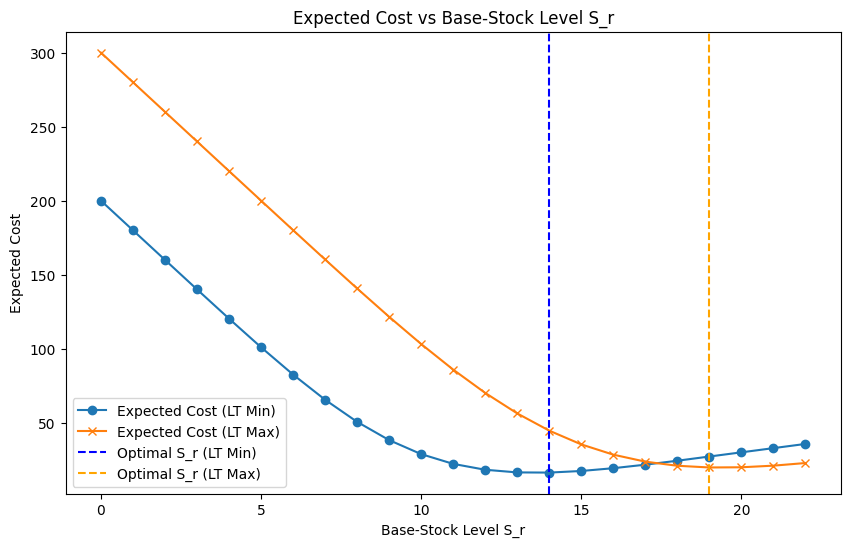

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(23), exp_cost_lt_min, label="Expected Cost (LT Min)", marker="o")
plt.plot(range(23), exp_cost_lt_max, label="Expected Cost (LT Max)", marker="x")
plt.axvline(sr_min, color="blue", linestyle="--", label="Optimal S_r (LT Min)")
plt.axvline(sr_max, color="orange", linestyle="--", label="Optimal S_r (LT Max)")
plt.title("Expected Cost vs Base-Stock Level S_r")
plt.xlabel("Base-Stock Level S_r")
plt.ylabel("Expected Cost")
plt.legend()

In [27]:
import numpy as np
from scipy.stats import poisson

# Step 2. Bounds of warehouse with given sr_min and sr_max


def func_exp_inv_w(base_stock_w):
    """
    Compute the warehouse's expected inventory outcomes for a given base-stock level.

    Parameters:
    - base_stock_w: warehouse reorder-up-to level S_w

    Returns:
    - exp_leftover: expected leftover inventory at the warehouse
    - exp_backorder: expected backorders at the warehouse
    """
    # 1. Compute mean demand over the warehouse lead time (fixed = lead_time[0])
    mu = _lambda * lead_time[0]

    # 2. Determine demand values up to the 99th percentile
    max_demand = poisson.ppf(0.99, mu)
    x = np.arange(max_demand + 1)  # possible demands 0,1,...,max_demand

    # 3. Compute probability of each demand level
    prob = poisson.pmf(x, mu)

    # 4. Expected leftover: E[max(S_w - X, 0)]
    leftover = np.fmax(base_stock_w - x, 0)  # leftover at each demand level
    exp_leftover = np.sum(leftover * prob)

    # 5. Expected backorder: E[max(X - S_w, 0)]
    backorder = np.fmax(x - base_stock_w, 0)  # backorder at each demand level
    exp_backorder = np.sum(backorder * prob)

    return exp_leftover, exp_backorder


def func_exp_total_cost(base_stock_w, base_stock_r):
    """
    Compute total expected cost for given warehouse and retailer base-stock levels.

    Parameters:
    - base_stock_w: warehouse reorder-up-to level S_w
    - base_stock_r: retailer reorder-up-to level S_r

    Returns:
    - exp_total_cost: expected total cost (warehouse holding + retailer cost)
    """
    # 1. Get warehouse inventory metrics
    exp_leftover_w, exp_backorder_w = func_exp_inv_w(base_stock_w)

    # 2. Approximate retailer lead time: fixed upstream lead_time[1]
    #    plus average delay from warehouse backorders
    exp_lt_r = lead_time[1] + exp_backorder_w / _lambda

    # 3. Compute total cost:
    #    - holding_cost[0] * exp_leftover_w = warehouse holding cost
    #    - func_exp_cost_r(...)           = retailer holding + penalty cost
    exp_total_cost = holding_cost[0] * exp_leftover_w + func_exp_cost_r(
        base_stock_r, exp_lt_r
    )
    return exp_total_cost


# Enumerate S_w values to find bounds given the retailer levels
exp_total_cost_sw_min = np.array(
    [
        func_exp_total_cost(s, sr_max)  # assume worst-case retailer S_r = sr_max
        for s in range(10)
    ]
)
exp_total_cost_sw_max = np.array(
    [
        func_exp_total_cost(s, sr_min)  # assume best-case retailer S_r = sr_min
        for s in range(10)
    ]
)

# Determine the warehouse base-stock that minimizes cost in each scenario
sw_min = np.argmin(exp_total_cost_sw_min)  # optimal S_w under sr_max
sw_max = np.argmin(exp_total_cost_sw_max)  # optimal S_w under sr_min

print("S_w lower bound: " + str(sw_min))
print("S_w upper bound: " + str(sw_max))

S_w lower bound: 1
S_w upper bound: 5


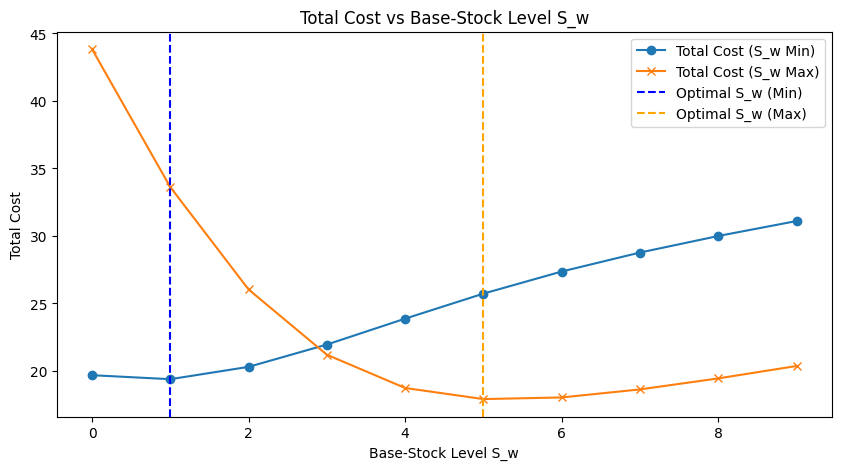

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(range(10), exp_total_cost_sw_min, label="Total Cost (S_w Min)", marker="o")
plt.plot(range(10), exp_total_cost_sw_max, label="Total Cost (S_w Max)", marker="x")
plt.axvline(sw_min, color="blue", linestyle="--", label="Optimal S_w (Min)")
plt.axvline(sw_max, color="orange", linestyle="--", label="Optimal S_w (Max)")
plt.title("Total Cost vs Base-Stock Level S_w")
plt.xlabel("Base-Stock Level S_w")
plt.ylabel("Total Cost")
plt.legend()
plt.show()

In [30]:
# Step 3. Enumerate all S_w and S_r within the previously found bounds
n_sw = sw_max - sw_min + 1  # number of warehouse base-stock candidates
n_sr = sr_max - sr_min + 1  # number of retailer base-stock candidates
total_cost_candidates = np.zeros(
    (n_sw, n_sr)
)  # matrix to hold total cost for each (S_w, S_r)

# 3a. Fill the cost matrix
for i in range(n_sw):
    for j in range(n_sr):
        # Evaluate total expected cost at:
        #   S_w = sw_min + i
        #   S_r = sr_min + j
        total_cost_candidates[i][j] = func_exp_total_cost(sw_min + i, sr_min + j)

# 3b. Print the full evaluation matrix
print("Evaluation for all possible S_w and S_r values:\n", total_cost_candidates)

# Step 4. Find the overall optimum
opt_cost = np.min(total_cost_candidates)  # the minimum total cost across all pairs

# Locate the indices (i,j) where the cost equals opt_cost
opt_indices = np.where(total_cost_candidates == opt_cost)
opt_sw = sw_min + opt_indices[0][0]  # warehouse level corresponding to min cost
opt_sr = sr_min + opt_indices[1][0]  # retailer level corresponding to min cost

# 4b. Output the optimal results
print("Optimal cost: " + str(opt_cost))
print("Optimal base-stock level of warehouse: S_w = " + str(opt_sw))
print("Optimal base-stock level of retailer: S_r = " + str(opt_sr))

Evaluation for all possible S_w and S_r values:
 [[33.61466022 26.87190895 22.39498702 19.89269496 19.01003086 19.38201289]
 [26.02837323 21.58081849 19.16493289 18.3984573  18.89228576 20.29560532]
 [21.19500078 18.69999557 17.91929303 18.43714268 19.88076078 21.94771424]
 [18.73031745 17.68646736 18.04379961 19.39861427 21.42175268 23.86779818]
 [17.90843482 17.81948428 18.88470216 20.73158969 23.07672844 25.72181791]]
Optimal cost: 17.68646735669163
Optimal base-stock level of warehouse: S_w = 4
Optimal base-stock level of retailer: S_r = 15


In [31]:
import plotly.graph_objects as go

# Define the range of base-stock levels for warehouse (S_w) and retailer (S_r)
sw_vals = np.arange(sw_min, sw_max + 1)
sr_vals = np.arange(sr_min, sr_max + 1)

# Create a meshgrid for plotting
SW, SR = np.meshgrid(sw_vals, sr_vals)
Z = np.zeros_like(SW, dtype=float)

# Compute total cost for each (S_w, S_r) pair
for i, sw in enumerate(sw_vals):
    for j, sr in enumerate(sr_vals):
        Z[j, i] = func_exp_total_cost(sw, sr)
# Compute overall min/max of Z so we can choose a bottom for the line
min_z, max_z = Z.min(), Z.max()
bottom_z = min_z - 0.05 * (max_z - min_z)  # a little bit below the lowest surface point

# 1) Surface, with opacity so lines show through
surface = go.Surface(
    x=SW,
    y=SR,
    z=Z,
    colorscale="Viridis",
    opacity=0.7,
    showscale=True,
    name="Total Cost",
)

# 2) Vertical line at the optimum, from bottom_z up to the true optimum cost
opt_line = go.Scatter3d(
    x=[opt_sw, opt_sw],
    y=[opt_sr, opt_sr],
    z=[bottom_z, opt_cost],
    mode="lines",
    line=dict(color="red", width=6),
    name="Optimum",
)

fig = go.Figure(data=[surface, opt_line])

fig.update_layout(
    title="Total Expected Cost Surface with Optimum",
    width=800,  # narrower
    height=400,  # taller
    margin=dict(l=0, r=0, b=0, t=40),
    scene=dict(
        xaxis_title="Warehouse S_w",
        yaxis_title="Retailer S_r",
        zaxis_title="Total Cost",
        aspectmode="manual",
        aspectratio=dict(x=1, y=1, z=2),
    ),
)

fig.show()